# 17_SIMBA_XENIUM_test

In [1]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.insert(1, '../scripts/benchmarking')

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from src.plot import plot_spatial, palette_celltype, plot_obs_spatial
import pandas as pd
import numpy as np
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "lightgray"
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import simba as si

workdir = 'data/17'
si.settings.set_workdir(workdir)

si.settings.set_figure_params(
    dpi=80,
    style='white',
    fig_size=[5,5],
    rc={'image.cmap': 'viridis'}
)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
import anndata as ad
from scipy.sparse import csr_matrix
# from manually added path
from spatial import gen_spatial_graph
from plot import plot_spatial_kernel
import squidpy as sq

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Saving results in: data/17


In [3]:
df = pd.read_parquet('/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/data/MCA205_d2_aPDL1/cells.parquet')
df = df.set_index('cell_id')

In [4]:
adata = sc.read_10x_h5("/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/data/MCA205_d2_aPDL1/cell_feature_matrix.h5")

In [5]:
adata.obs = df.loc[adata.obs.index]
adata.obsm['spatial'] = adata.obs[['x_centroid', 'y_centroid']].to_numpy()

In [8]:
si.pp.cal_qc_rna(adata)

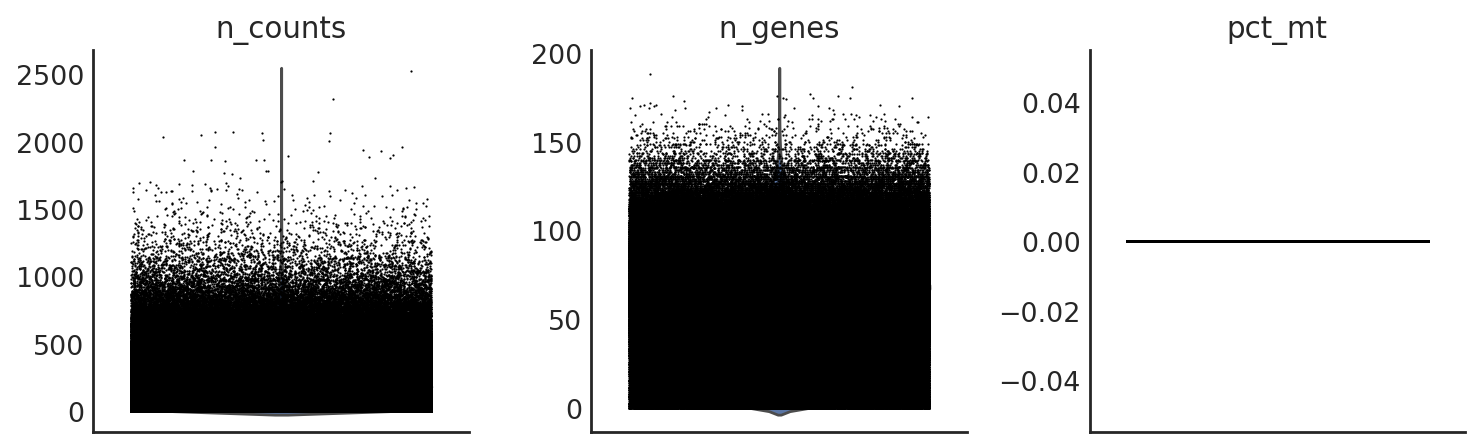

In [9]:
si.pl.violin(adata,list_obs=['n_counts','n_genes','pct_mt'])

Following this tutorial: https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_xenium.html

In [14]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

In [15]:
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.007295434363353483
Negative decoding count % : 0.0037807053070559524


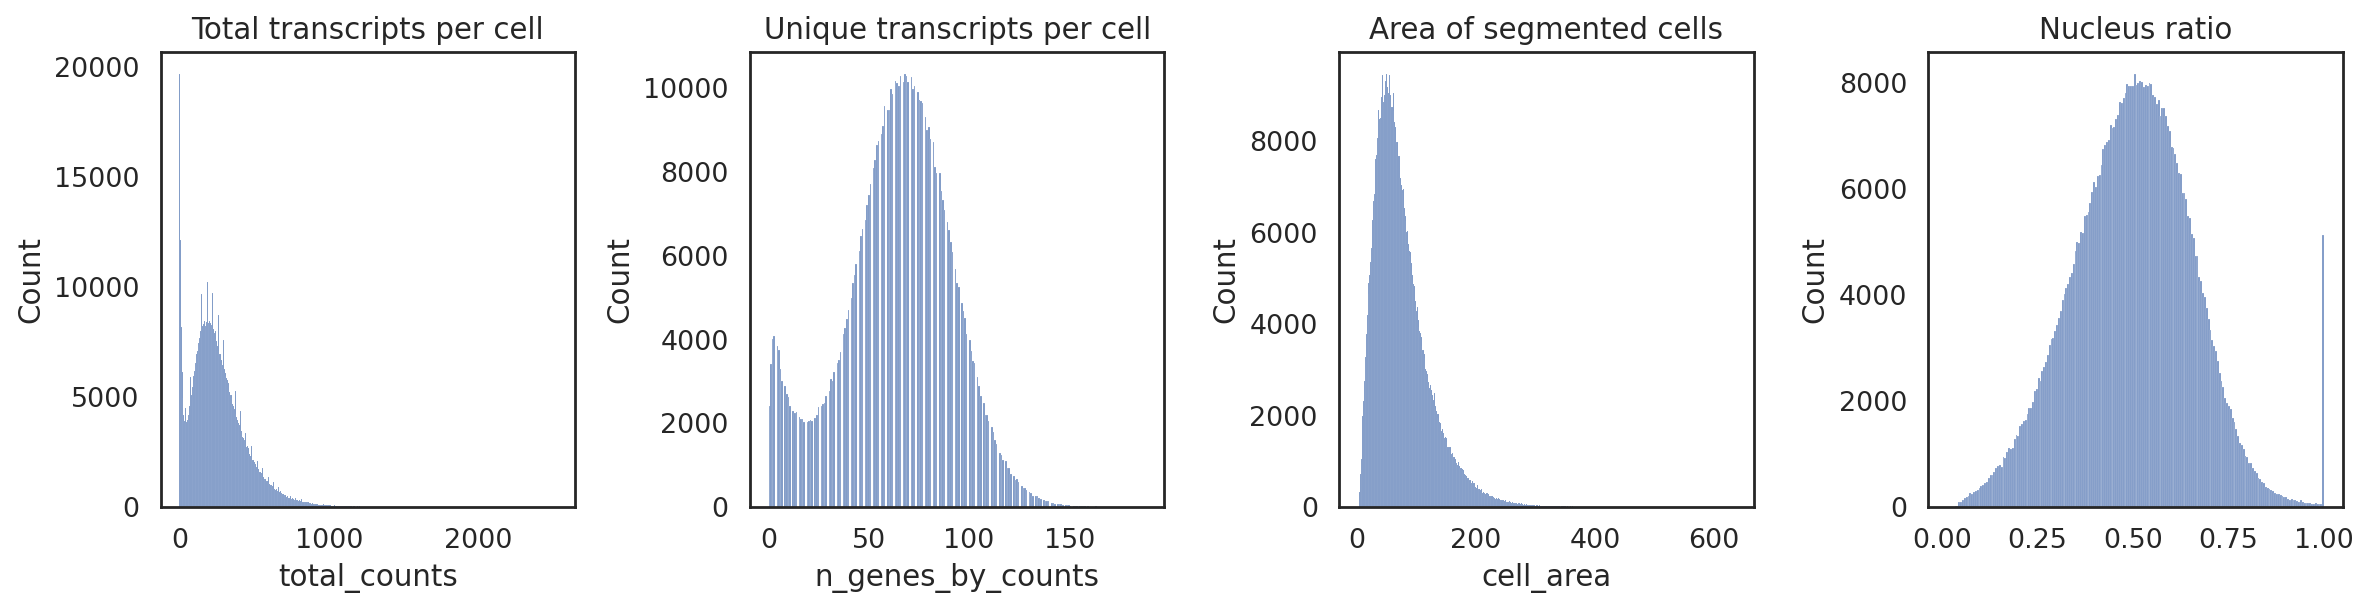

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    adata.obs["nucleus_area"] / adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)
plt.tight_layout()
plt.show()

In [18]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

In [19]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

/tmp/ipykernel_1585192/4193936636.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


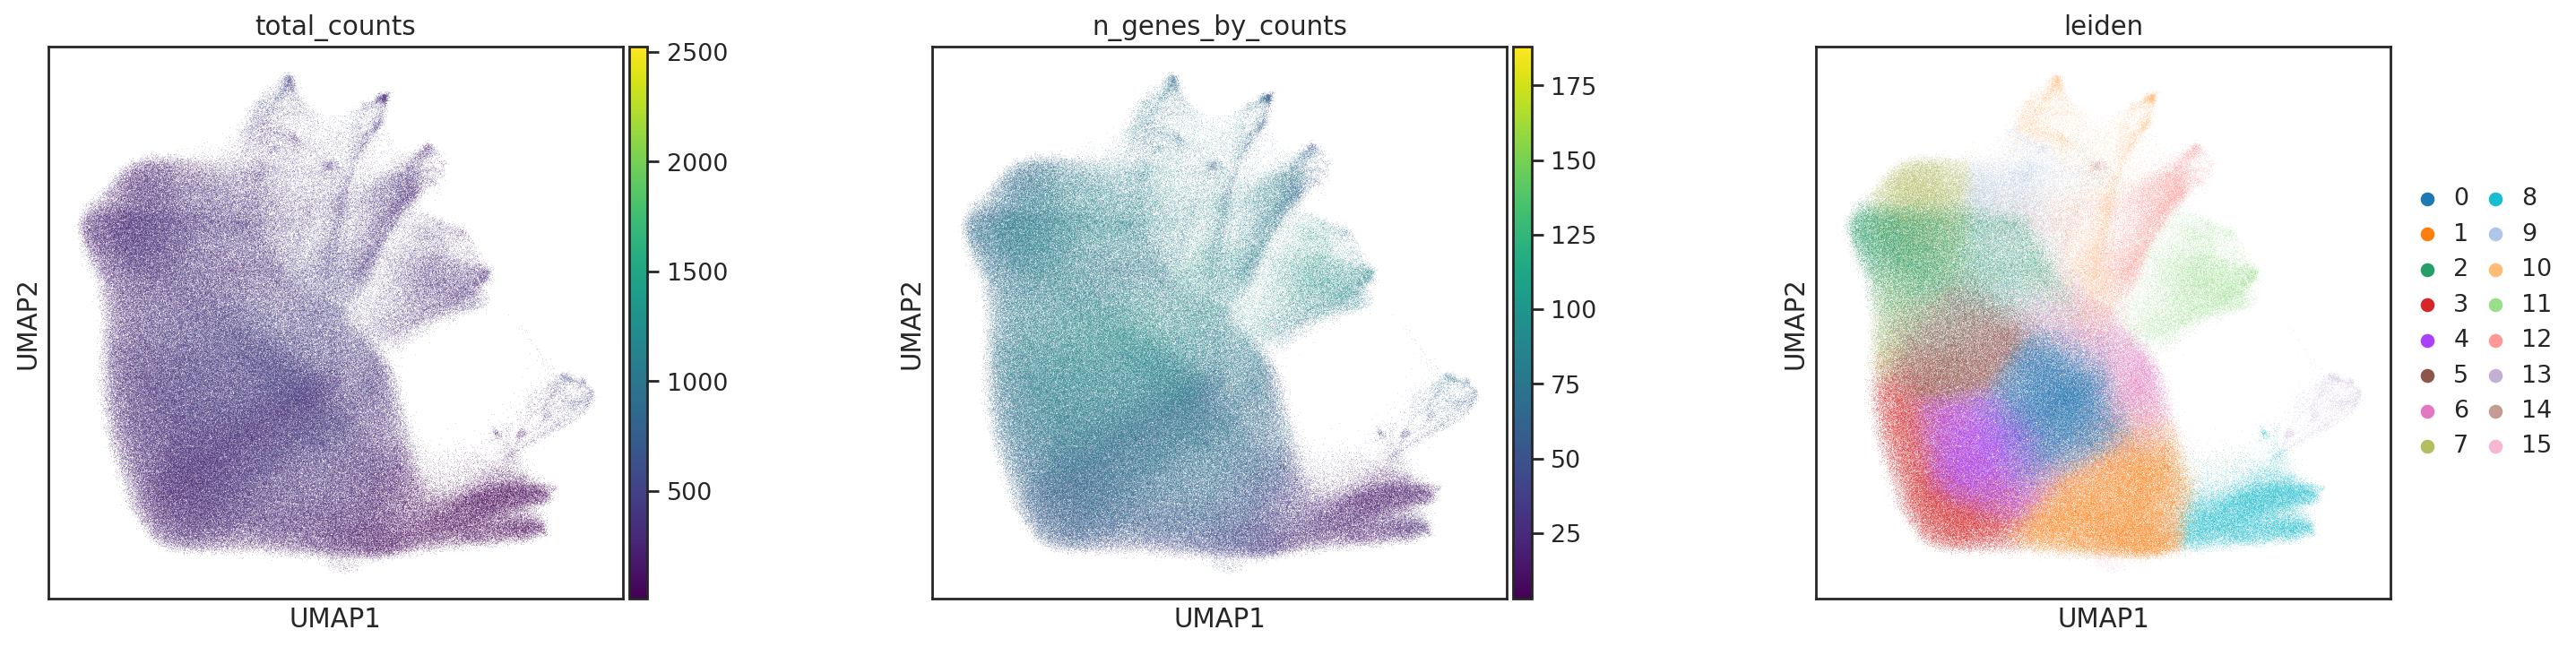

In [20]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.4,
)

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


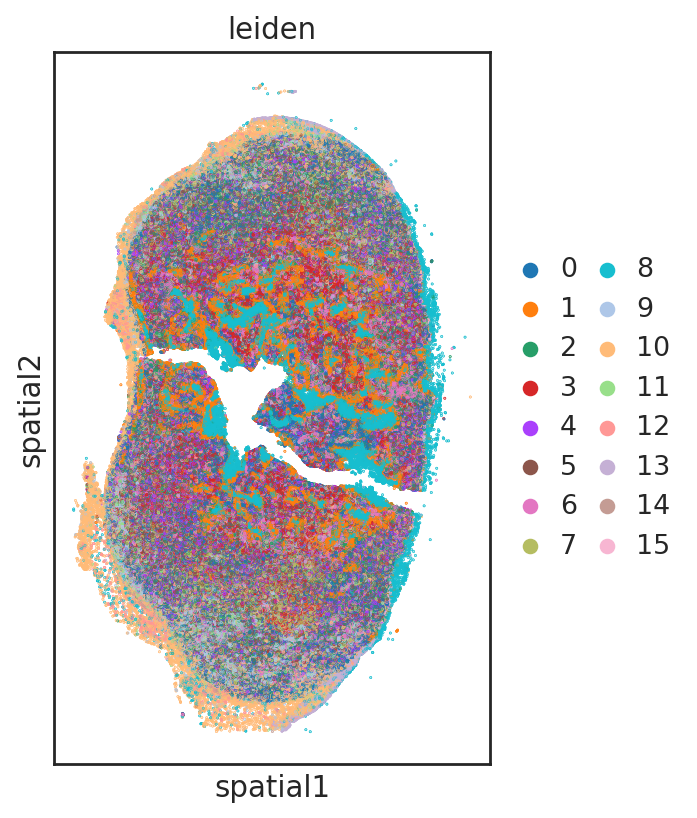

In [21]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

# SIMBA RNA alone

In [ ]:
adata.shape

In [26]:
adata.var['feature_types'].value_counts()

feature_types
Gene Expression    335
Name: count, dtype: int64

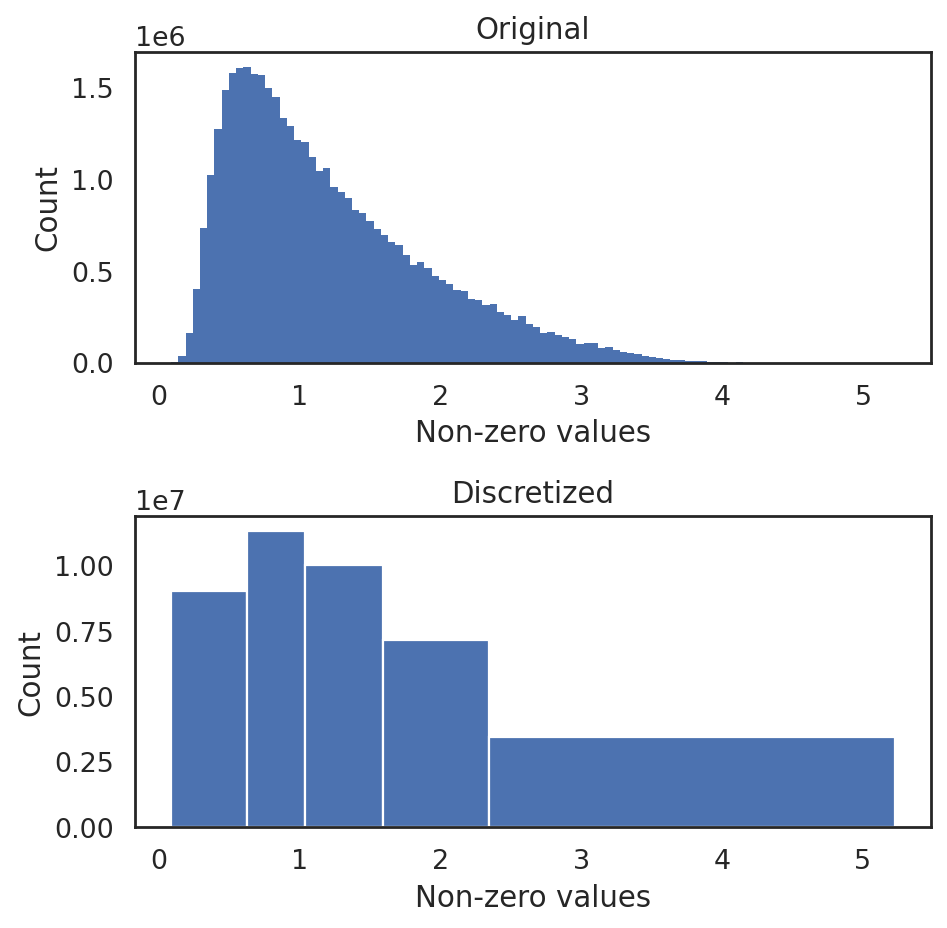

In [27]:
si.tl.discretize(adata,n_bins=5)
si.pl.discretize(adata,kde=False)

In [28]:
si.tl.gen_graph(list_CG=[adata],
                layer='simba',
                use_highly_variable=False,
                dirname='graph_rna')

relation0: source: C, destination: G
#edges: 9029653
relation1: source: C, destination: G
#edges: 11342255


In [ ]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_rna')